In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.patches import Rectangle, Circle
from matplotlib.lines import Line2D

import MDAnalysis as mda

/home/kirill/miniforge3/envs/emle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
u = mda.Universe('3MIw.prmtop')

NAME_MAP = {'N1': 'N$_1$', 
            'C2': 'C$_3$', 
            'C3': 'C$_2$',  
            'C4': 'C$_4$',  
            'C6': 'C$_5$',  
            'C7': 'C$_8$',  
            'C8': 'C$_6$',  
            'C9': 'C$_7$',  
            'H3': 'H$_2$'}

def get_prop_name(index, kind):
    return '-'.join(NAME_MAP[atom.name] for atom in getattr(u, kind)[index].atoms)

def get_bond_name(index):
    return get_prop_name(index, 'bonds')

def get_angle_name(index):
    return get_prop_name(index, 'angles')

def get_dihedral_name(index):
    return get_prop_name(index, 'dihedrals')

/home/kirill/miniforge3/envs/emle/lib/python3.11/site-packages/MDAnalysis/core/universe.py:150: UserWarning: No coordinate reader found for 3MIw.prmtop. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


In [3]:
data = scipy.io.loadmat('wB97X/geom.mat', squeeze_me=True)

In [4]:
COLOR_MM = '#ff7f0e'
COLOR_MLMM = '#1f77b4'

def get_errors(kind_data, project=False):
    errors = kind_data[1:] - kind_data[0]
    if project:
        errors = project_dihedrals(errors)
    return (np.abs(np.mean(_, axis=0)) for _ in errors)

def project_dihedrals(x):
    return (x + 180) % 360 - 180

def plot_errors(ax, values_mm, values_mlmm, ylabel):
    x = np.arange(len(values_mm))
    ax.scatter(x, values_mm, c=COLOR_MM, s=24).set_clip_on(False)
    ax.scatter(x, values_mlmm, c=COLOR_MLMM, s=24).set_clip_on(False)     
    ax.set_ylabel(ylabel)
    ax.set_xticks([])

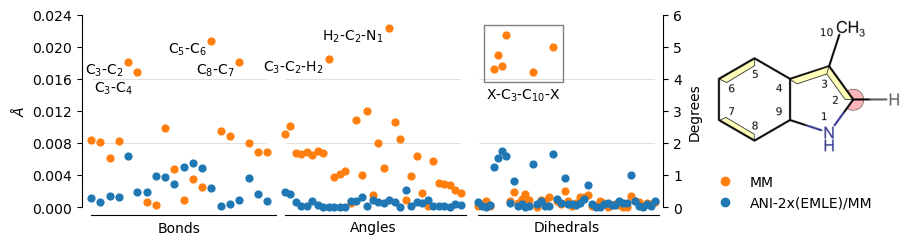

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))

mm_bond_errors, mlmm_bond_errors = get_errors(data['bonds'])
plot_errors(axs[0], mm_bond_errors, mlmm_bond_errors, '$\AA$')

for i in [4, 13, 16]:
    axs[0].text(i - 0.5, np.abs(mm_bond_errors[i]), get_bond_name(i), 
                horizontalalignment='right', verticalalignment='top')
axs[0].text(4.5, np.abs(mm_bond_errors[5]) - 0.001, get_bond_name(5),
            horizontalalignment='right', verticalalignment='top')

axs[0].set_xlabel('Bonds')
axs[0].set_ylim([0, 0.024])
axs[0].set_yticks(np.linspace(0, 0.024, 7, endpoint=True))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_position(('data', -0.001))
axs[0].spines['bottom'].set_bounds(0, len(mm_bond_errors))
for y in (0.008, 0.016):
    axs[0].axhline(y=y, xmin=0.05, xmax=0.95, color='lightgrey', linewidth=0.5, zorder=-1)

mm_angle_errors, mlmm_angle_errors = get_errors(data['angles'])
plot_errors(axs[1], mm_angle_errors, mlmm_angle_errors, 'Degrees')

for i in [8, 19]:
    axs[1].text(i - 1, np.abs(mm_angle_errors[i]), get_angle_name(i), 
                horizontalalignment='right', verticalalignment='top')

axs[1].set_xlabel('Angles')
axs[1].spines['bottom'].set_bounds(0, len(mm_angle_errors))
axs[2].set_xlabel('Dihedrals')
for ax in axs[1:3]:
    ax.set_ylim([0, 6])
    ax.yaxis.set_visible(False)
    for y in (2, 4):
        ax.axhline(y=y, xmin=0.05, xmax=0.95, color='lightgrey', 
                   linewidth=0.5, zorder=-1)
    for spine in ('top', 'right', 'left'):
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_position(('data', -0.23))


ax_dih = axs[2].twinx()

mm_dihedral_errors, mlmm_dihedral_errors = get_errors(data['dihedrals'], True)
plot_errors(ax_dih, mm_dihedral_errors, mlmm_dihedral_errors, 'Degrees')

axs[2].spines['bottom'].set_bounds(0, len(mm_dihedral_errors))

ax_dih.set_ylim([0, 6])
ax_dih.spines['top'].set_visible(False)
ax_dih.spines['left'].set_visible(False)
ax_dih.spines['bottom'].set_visible(False) 

rect = Rectangle((1.5, 3.9), 20, 1.8, linewidth=1, edgecolor='grey', facecolor='none', zorder=0)
ax_dih.add_patch(rect)
ax_dih.text(11.5, 3.75, 'X-C$_3$-C$_{10}$-X', 
            horizontalalignment='center', verticalalignment='top')

plt.subplots_adjust(wspace=0)

axs[3].axis('off')
pos = axs[3].get_position()
axs[3].set_position([pos.x0 + 0.05, pos.y0 + 0.2, pos.width, pos.height - 0.2])
img = image.imread('3mi_errors.png')
axs[3].imshow(img)

legend_items = [
    Line2D([0], [0], marker='o', color='w', 
           markerfacecolor=COLOR_MM, label='MM', markersize=8),
    Line2D([0], [0], marker='o', color='w', 
           markerfacecolor=COLOR_MLMM, label='ANI-2x(EMLE)/MM', markersize=8)
]
fig.legend(handles=legend_items, loc='center left', bbox_to_anchor=(0.741, 0.17), ncol=1, frameon=False)

plt.savefig('Fig5.png', dpi=300, bbox_inches='tight')